# Figures for the Lesion Size 2020 dataset

### Accompanying the publication "Lesion size matters: A validation dataset for melanoma detection"

This notebook was compiled by Emily Cohen and Jochen Weber.
For corrections, please email Jochen at weberj3 (at) mskcc.org.

In [1]:
# imports
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

# settings
sns.set(rc={'figure.figsize':(20,15)})
sns.set_theme(style="whitegrid")

In [2]:
# load data
data = pd.read_csv('lesion-size-2020_metadata.csv').set_index('image_name')

# round mpath values for display
data['mpath'] = np.around(data.mpath.values).astype(np.int32)

# add log-odds of ADAE score (for plotting) and text variables
data['adae_lo'] = np.log((data.adae_score.values / (1.0 - data.adae_score.values)))
data['status'] = ['melanoma' if v > 0 else 'benign' for v in data.target.values]
data['lesion size'] = ['small-diameter' if v > 0 else 'large-diameter' for v in data.tiny.values]

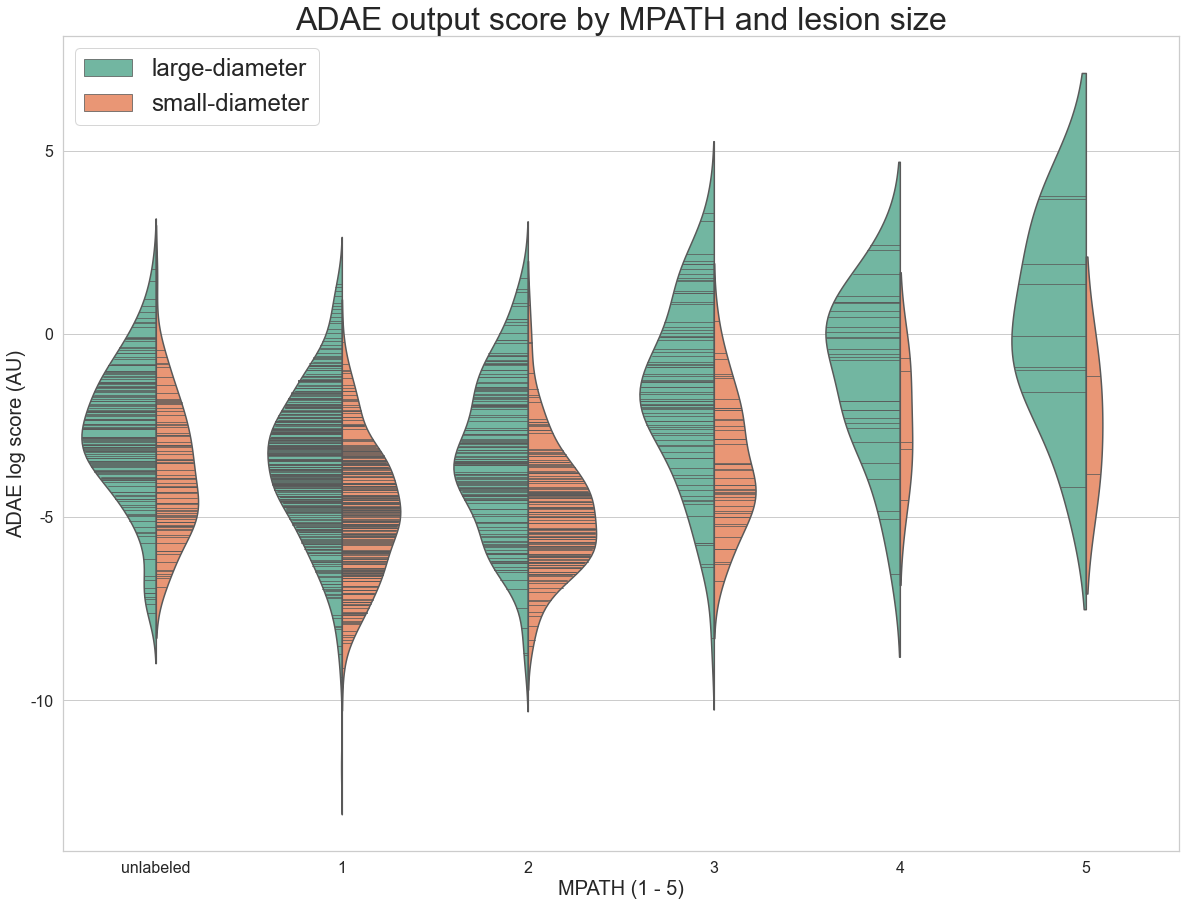

In [3]:
# Violin plot (ADAE scores vs. MPATH)
ax = sns.violinplot(x="mpath", y="adae_lo", hue="lesion size", data=data,
                    palette="Set2", inner="stick", split=True, scale="count")
ax.set_xlabel('MPATH (1 - 5)', fontsize=20.0)
ax.set_xticklabels(['unlabeled', '1', '2', '3', '4', '5'], fontdict={'fontsize': 16.0})
ax.set_ylabel('ADAE log score (AU)', fontsize=20.0)
ax.set_yticks(np.arange(-10.0, 10.0, 5.0))
ax.set_yticklabels(['-10', '-5', '0', '5'], fontdict={'fontsize': 16.0})
ax.legend(loc='upper left', fontsize=24.0)
ax.set_title('ADAE output score by MPATH and lesion size', fontsize=32.0)
mpl.pyplot.savefig('ADAE_by_MPATH.png', dpi=300)

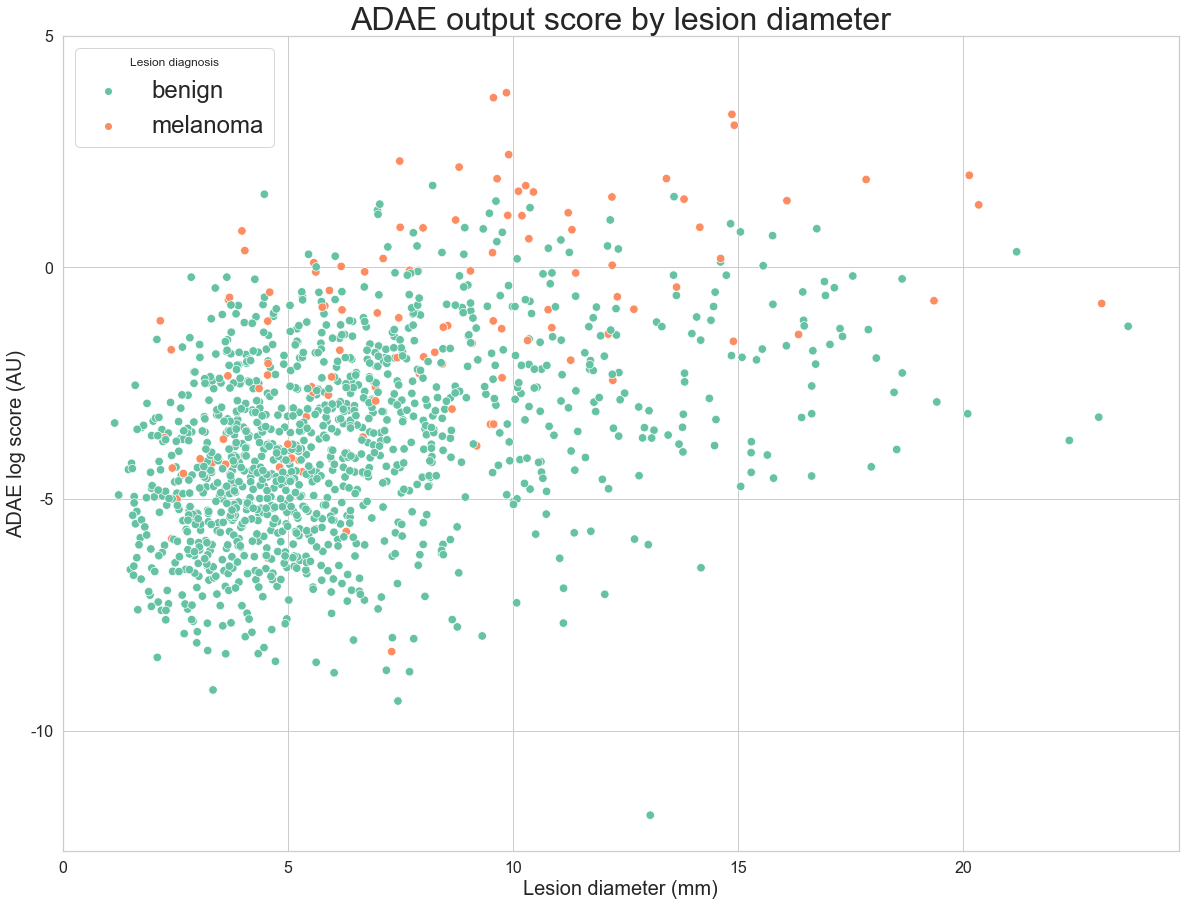

In [4]:
# Scatter plot (ADAE scores vs. diameter)
ax = sns.scatterplot(x="diameter", y="adae_lo", data=data,
                     hue="status", palette="Set2", s=72)
ax.set_xlabel('Lesion diameter (mm)', fontsize=20.0)
ax.set_xticks(np.arange(0.0, 25.0, 5.0))
ax.set_xticklabels(['0', '5', '10', '15', '20'], fontdict={'fontsize': 16.0})
ax.set_ylabel('ADAE log score (AU)', fontsize=20.0)
ax.set_yticks(np.arange(-10.0, 10.0, 5.0))
ax.set_yticklabels(['-10', '-5', '0', '5'], fontdict={'fontsize': 16.0})
al = ax.legend(loc='upper left', title='Lesion diagnosis', fontsize=24.0)
ax.set_title('ADAE output score by lesion diameter', fontsize=32.0)
mpl.pyplot.savefig('ADAE_by_diameter.png', dpi=300)

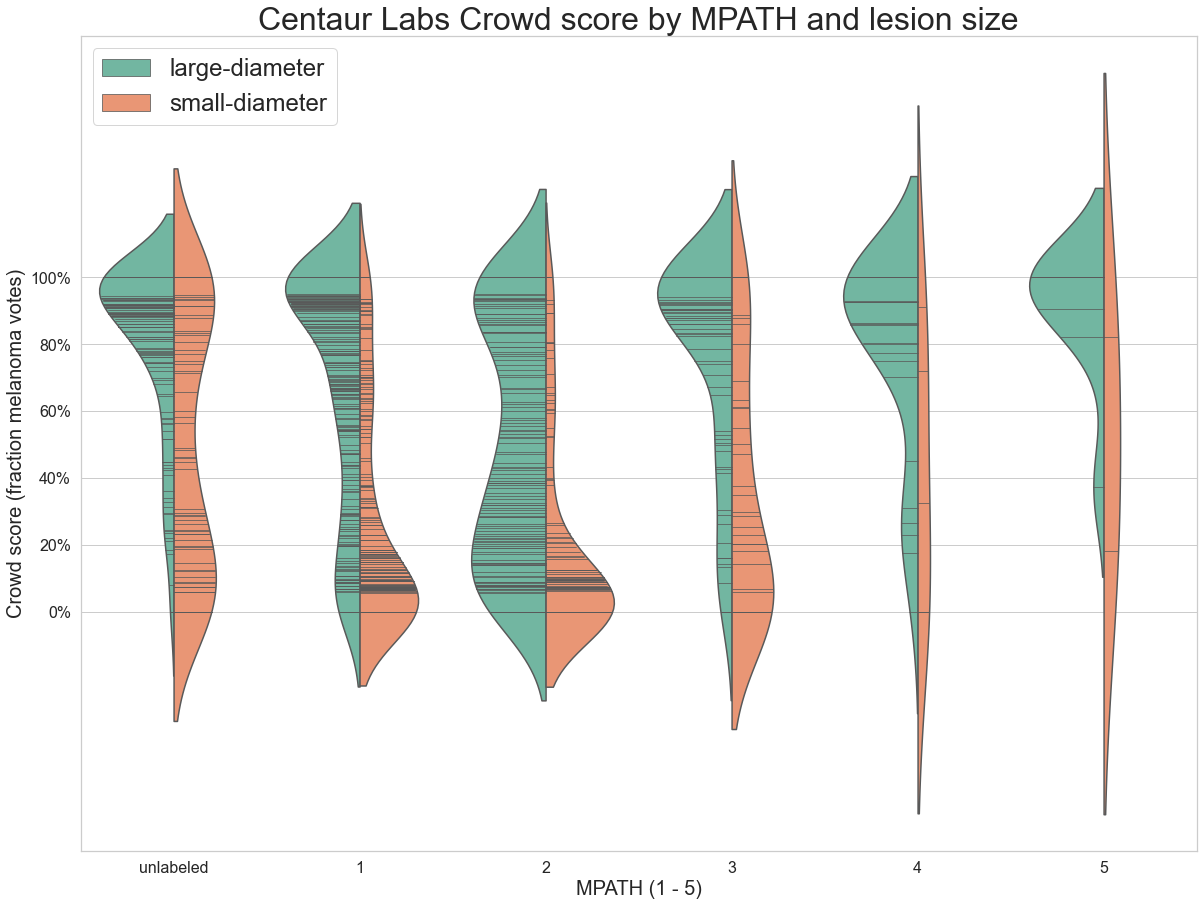

In [5]:
# Violin plot (CL scores vs. MPATH)
ax = sns.violinplot(x="mpath", y="crowd_score", hue="lesion size", data=data,
                    palette="Set2", inner="stick", split=True, scale="count")
ax.set_xlabel('MPATH (1 - 5)', fontsize=20.0)
ax.set_xticklabels(['unlabeled', '1', '2', '3', '4', '5'], fontdict={'fontsize': 16.0})
ax.set_ylabel('Crowd score (fraction melanoma votes)', fontsize=20.0)
ax.set_yticks(np.arange(0.0, 1.01, 0.2))
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontdict={'fontsize': 16.0})
ax.legend(loc='upper left', fontsize=24.0)
ax.set_title('Centaur Labs Crowd score by MPATH and lesion size', fontsize=32.0)
mpl.pyplot.savefig('CL_by_MPATH.png', dpi=300)

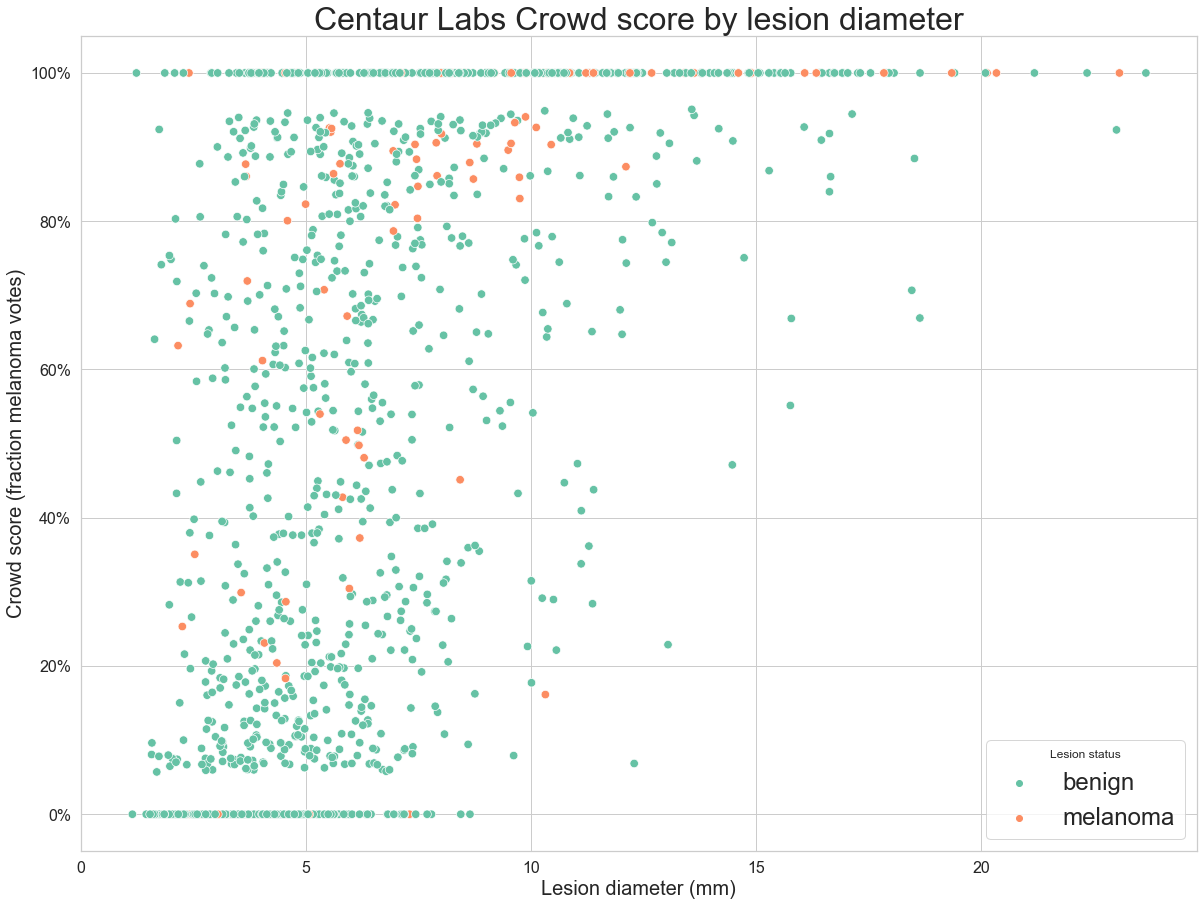

In [6]:
# Scatter plot (CL scores vs. diameter)
ax = sns.scatterplot(x="diameter", y="crowd_score", data=data,
                     hue="status", palette="Set2", s=72)
ax.set_xlabel('Lesion diameter (mm)', fontsize=20.0)
ax.set_xticks(np.arange(0.0, 25.0, 5.0))
ax.set_xticklabels(['0', '5', '10', '15', '20'], fontdict={'fontsize': 16.0})
ax.set_ylabel('Crowd score (fraction melanoma votes)', fontsize=20.0)
ax.set_yticks(np.arange(0.0, 1.01, 0.2))
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontdict={'fontsize': 16.0})
ax.legend(loc='lower right', title='Lesion status', fontsize=24.0)
ax.set_title('Centaur Labs Crowd score by lesion diameter', fontsize=32.0)
mpl.pyplot.savefig('CL_by_diameter.png', dpi=300)

## This section performs a logistic (probabilistic) regression

In [7]:
# some basic logistic regression
from sklearn.linear_model import LogisticRegression

In [8]:
# create age-x-diameter interaction term
age = data.age.values;
age = age - age.mean()
dia = data.diameter.values;
dia = dia - dia.mean()
a_d = age * dia
a_d = a_d / a_d.std()
a_d = a_d - a_d.mean()
data['age_diam'] = a_d
data['is_female'] = [1 if v == 'female' else 0 for v in data.sex.values]
data['intercept'] = [1] * len(data)

In [9]:
# run regression (change list of variables for different models!)
clf = LogisticRegression(random_state=0).fit(
    data[['intercept', 'age', 'diameter', 'age_diam', 'is_female']], data[['target']])

/Users/weberj3/opt/miniconda3/envs/dermopolis/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
data['log_reg_prob'] = clf.predict_proba(data[['intercept', 'age', 'diameter', 'age_diam', 'is_female']])[:,1]
data.to_csv('lesion-size-2020_metadata_extended.csv')

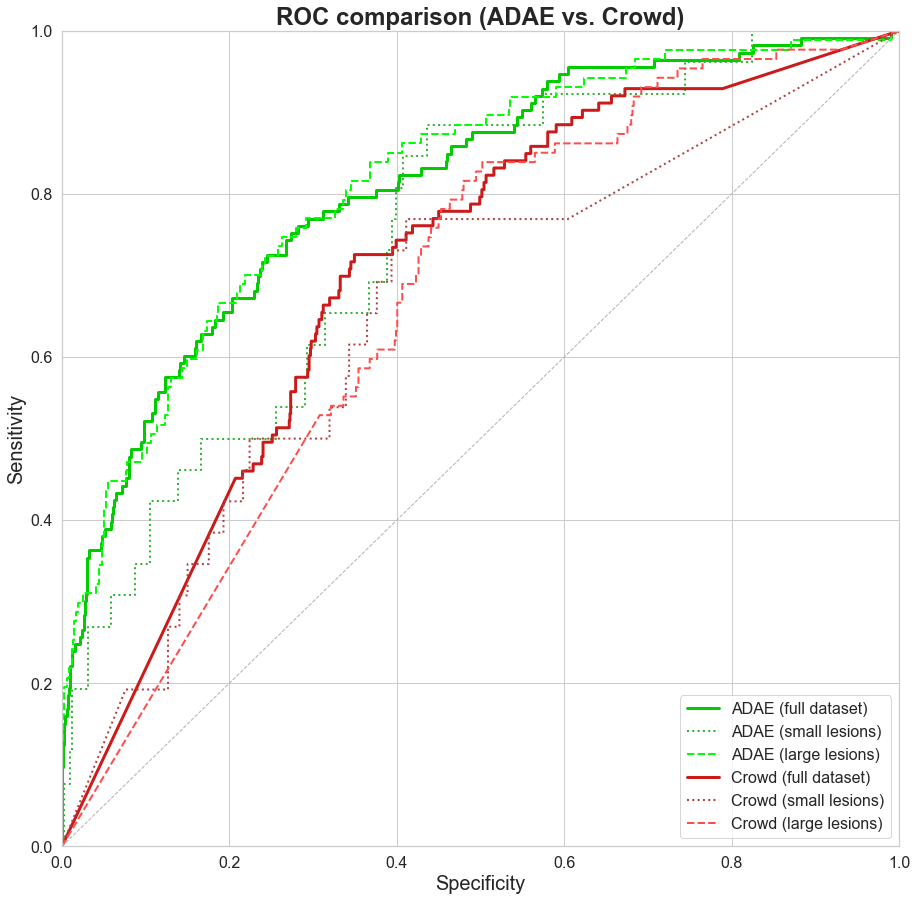

In [11]:
# compute ROC and AUC measures
from sklearn import metrics

small_lesions = data.tiny.values > 0
large_lesions = data.tiny.values == 0

adae_full_fpr, adae_full_tpr, thr = metrics.roc_curve(
    data.target.values, data.adae_score.values, pos_label=1)
adae_full_auc = metrics.auc(adae_full_fpr, adae_full_tpr)
adae_small_fpr, adae_small_tpr, thr = metrics.roc_curve(
    data.target.values[small_lesions], data.adae_score.values[small_lesions], pos_label=1)
adae_small_auc = metrics.auc(adae_small_fpr, adae_small_tpr)
adae_large_fpr, adae_large_tpr, thr = metrics.roc_curve(
    data.target.values[large_lesions], data.adae_score.values[large_lesions], pos_label=1)
adae_large_auc = metrics.auc(adae_large_fpr, adae_large_tpr)

clabs_full_fpr, clabs_full_tpr, thr = metrics.roc_curve(
    data.target.values, data.crowd_score.values, pos_label=1)
clabs_full_auc = metrics.auc(clabs_full_fpr, clabs_full_tpr)
clabs_small_fpr, clabs_small_tpr, thr = metrics.roc_curve(
    data.target.values[small_lesions], data.crowd_score.values[small_lesions], pos_label=1)
clabs_small_auc = metrics.auc(clabs_small_fpr, clabs_small_tpr)
clabs_large_fpr, clabs_large_tpr, thr = metrics.roc_curve(
    data.target.values[large_lesions], data.crowd_score.values[large_lesions], pos_label=1)
clabs_large_auc = metrics.auc(clabs_large_fpr, clabs_large_tpr)

lreg_full_fpr, lreg_full_tpr, thr = metrics.roc_curve(
    data.target.values, data.log_reg_prob.values, pos_label=1)
lreg_full_auc = metrics.auc(lreg_full_fpr, lreg_full_tpr)
lreg_small_fpr, lreg_small_tpr, thr = metrics.roc_curve(
    data.target.values[small_lesions], data.log_reg_prob.values[small_lesions], pos_label=1)
lreg_small_auc = metrics.auc(lreg_small_fpr, lreg_small_tpr)
lreg_large_fpr, lreg_large_tpr, thr = metrics.roc_curve(
    data.target.values[large_lesions], data.log_reg_prob.values[large_lesions], pos_label=1)
lreg_large_auc = metrics.auc(lreg_large_fpr, lreg_large_tpr)


# add/remove undesired components
mpl.pyplot.figure(figsize=(15, 15,))

mpl.pyplot.plot(
    adae_full_fpr, adae_full_tpr, label="ADAE (full dataset)", color=(0.0, 0.8, 0.0,), linestyle='-', linewidth=3.0)
mpl.pyplot.plot(
    adae_small_fpr, adae_small_tpr, label="ADAE (small lesions)", color=(0.2, 0.7, 0.2,), linestyle=':', linewidth=2.0)
mpl.pyplot.plot(
    adae_large_fpr, adae_large_tpr, label="ADAE (large lesions)", color=(0.0, 1.0, 0.0,), linestyle='--', linewidth=2.0)

mpl.pyplot.plot(
    clabs_full_fpr, clabs_full_tpr, label="Crowd (full dataset)", color=(0.8, 0.1, 0.1,), linestyle='-', linewidth=3.0)
mpl.pyplot.plot(
    clabs_small_fpr, clabs_small_tpr, label="Crowd (small lesions)", color=(0.7, 0.25, 0.25,), linestyle=':', linewidth=2.0)
mpl.pyplot.plot(
    clabs_large_fpr, clabs_large_tpr, label="Crowd (large lesions)", color=(1.0, 0.3, 0.3,), linestyle='--', linewidth=2.0)

# mpl.pyplot.plot(
#     lreg_full_fpr, lreg_full_tpr, label="Log-reg (full dataset)", color=(0.2, 0.2, 0.9,), linestyle='-', linewidth=2.0)
# mpl.pyplot.plot(
#     lreg_small_fpr, lreg_small_tpr, label="Log-reg (small lesions)", color=(0.4, 0.4, 1.0,), linestyle=':', linewidth=1.5)
# mpl.pyplot.plot(
#     lreg_large_fpr, lreg_large_tpr, label="Log-reg (large lesions)", color=(0.3, 0.3, 0.95,), linestyle='--', linewidth=1.5)

# diagonal
mpl.pyplot.plot([0, 1], [0, 1], "--", color=(0.7, 0.7, 0.7,), linewidth=1.0)

# formating
mpl.pyplot.xlim((0.0, 1.0,))
mpl.pyplot.ylim((0.0, 1.0,))
mpl.pyplot.title('ROC comparison (ADAE vs. Crowd)', fontsize=24.0, fontweight='bold')
mpl.pyplot.xticks(fontsize=16.0)
mpl.pyplot.xlabel('Specificity', fontsize=20.0)
mpl.pyplot.yticks(fontsize=16.0)
mpl.pyplot.ylabel('Sensitivity', fontsize=20.0)
mpl.pyplot.legend(fontsize=16.0, loc='lower right')
mpl.pyplot.savefig('ROC_comparison.png', dpi=300)

In [12]:
# print out AUC values
print('AUC(ADAE-full) = {0:.3f}'.format(adae_full_auc))
print('AUC(ADAE-small) = {0:.3f}'.format(adae_small_auc))
print('AUC(ADAE-small) = {0:.3f}'.format(adae_large_auc))
print()
print('AUC(Crowd-full) = {0:.3f}'.format(clabs_full_auc))
print('AUC(Crowd-small) = {0:.3f}'.format(clabs_small_auc))
print('AUC(Crowd-small) = {0:.3f}'.format(clabs_large_auc))
print()
print('AUC(LogReg-full) = {0:.3f}'.format(lreg_full_auc))
print('AUC(LogReg-small) = {0:.3f}'.format(lreg_small_auc))
print('AUC(LogReg-small) = {0:.3f}'.format(lreg_large_auc))


AUC(ADAE-full) = 0.810
AUC(ADAE-small) = 0.752
AUC(ADAE-small) = 0.816

AUC(Crowd-full) = 0.703
AUC(Crowd-small) = 0.658
AUC(Crowd-small) = 0.673

AUC(LogReg-full) = 0.732
AUC(LogReg-small) = 0.739
AUC(LogReg-small) = 0.687
